In [1]:
# Imports
import pandas as pd
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel, VoigtModel, LinearModel, ConstantModel, SkewedGaussianModel
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statistics import mean, median
from scipy.stats import skewnorm, gamma
from tqdm import tqdm
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import numpy as np
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statistics import mean, median
from tensorflow.keras import models, layers
from tensorflow.keras.layers import BatchNormalization, Activation, Conv1D, Input, Flatten, Dense, Dropout, MaxPool1D
from tensorflow.keras.optimizers import schedules, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import HeNormal
import tensorflow as tf
import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from keras import regularizers, losses, metrics

In [2]:
# Load the dataset
df = pd.read_csv('train_dataset_RAW.csv')

In [4]:
# Parse the dataset
c = df['C']
si = df['Si']
mn = df['Mn']
cr = df['Cr']
mo = df['Mo']
ni = df['Ni']
cu = df['Cu']
fe = df['Fe']
clean_df=df.T
clean_df.drop(clean_df.tail(8).index, inplace=True)
clean_df.index = clean_df.index.to_series().astype(str).str.replace('X','',regex=True).astype(float)
clean_df.index = clean_df.index.astype(float)

In [12]:
# Divide data into training and testing set and reshape
unique_test_id = [1, 6, 14, 24, 26, 30, 39]
test_id = [list(range(i*50,i*50+50)) for i in unique_test_id]
test_id = [item for sublist in test_id for item in sublist]
x_train = clean_df.drop(test_id, axis=1).to_numpy()
y_train = mn.drop(test_id).to_numpy()
x_test = clean_df.iloc[:,test_id].to_numpy()
y_test = mn.iloc[test_id].to_numpy()
x_train = np.swapaxes(x_train, 0, 1)
x_test = np.swapaxes(x_test, 0, 1)

In [13]:
# Scale data
x_scaler_mean = np.mean(x_train)
x_scaler_std = np.std(x_train)

X_train = (x_train[:,:, np.newaxis]-x_scaler_mean)/x_scaler_std
X_test = (x_test[:, :, np.newaxis]-x_scaler_mean)/x_scaler_std

In [14]:
# Model architecture
def buildmodel():
    model = models.Sequential()
    model.add(layers.Conv1D(3, 3, activation='relu', input_shape = (40002 ,1)))
    model.add(layers.MaxPooling1D(pool_size = 2))
    model.add(layers.Conv1D(5, 5, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size = 2))
    model.add(layers.Conv1D(7, 7, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="linear"))



    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
    return model
    
model = buildmodel()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 40000, 3)          12        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 20000, 3)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 19996, 5)          80        
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 9998, 5)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 9992, 7)           252       
                                                                 
 flatten_1 (Flatten)         (None, 69944)            

In [21]:
history = model.fit(X_train, y_train, epochs=20, batch_size=10, validation_split=0.1)

Epoch 1/20
158/158 [==============================] - 11s 70ms/step - loss: 2.3591 - mae: 1.1371 - val_loss: 2.8468 - val_mae: 1.1752
Epoch 2/20
158/158 [==============================] - 12s 74ms/step - loss: 1.7663 - mae: 0.9537 - val_loss: 2.7134 - val_mae: 1.1267
Epoch 3/20
158/158 [==============================] - 13s 83ms/step - loss: 1.5217 - mae: 0.8770 - val_loss: 2.7689 - val_mae: 1.1736
Epoch 4/20
158/158 [==============================] - 13s 82ms/step - loss: 1.3016 - mae: 0.8401 - val_loss: 5.3743 - val_mae: 1.7358
Epoch 5/20
158/158 [==============================] - 13s 84ms/step - loss: 1.1308 - mae: 0.7893 - val_loss: 1.8788 - val_mae: 0.9575
Epoch 6/20
158/158 [==============================] - 13s 85ms/step - loss: 0.7987 - mae: 0.6640 - val_loss: 2.6852 - val_mae: 1.1827
Epoch 7/20
158/158 [==============================] - 13s 84ms/step - loss: 0.5377 - mae: 0.5573 - val_loss: 2.3231 - val_mae: 1.1238
Epoch 8/20
158/158 [==============================] - 13s 83ms

11/11 [==============================] - 1s 69ms/step


0.06813466330936979

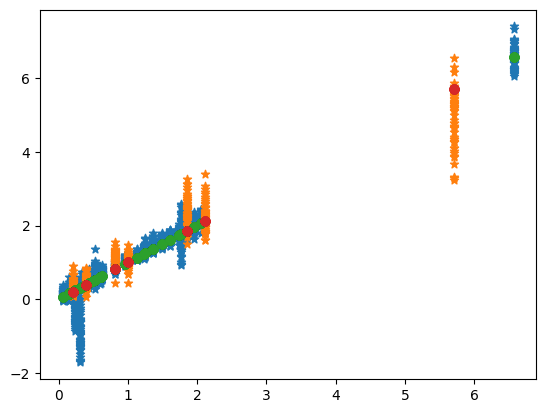

In [16]:
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

plt.scatter(x=y_train, y=Y_pred_train, marker='*')
plt.scatter(x=y_test, y=Y_pred_test, marker='*')
plt.scatter(x=y_train, y=y_train, marker='o')
plt.scatter(x=y_test, y=y_test, marker='o')
np.sqrt(np.mean(Y_pred_test-y_test)**2)

In [17]:
#XVD
k_selections = 10
test_sample_size = 7
RMSE_list = np.zeros(k_selections)
for k in tqdm(range(k_selections)):
    # Divide data into training and testing set and reshape
    unique_test_id = random.sample(range(42),test_sample_size)
    test_id = [list(range(i*50,i*50+50)) for i in unique_test_id]
    test_id = [item for sublist in test_id for item in sublist]
    x_train = clean_df.drop(test_id, axis=1).to_numpy()
    y_train = cr.drop(test_id).to_numpy()
    x_test = clean_df.iloc[:,test_id].to_numpy()
    y_test = cr.iloc[test_id].to_numpy()
    x_train = np.swapaxes(x_train, 0, 1)
    x_test = np.swapaxes(x_test, 0, 1)
    # Scale data
    x_scaler_mean = np.mean(x_train)
    x_scaler_std = np.std(x_train)
    X_train = (x_train[:,:, np.newaxis]-x_scaler_mean)/x_scaler_std
    X_test = (x_test[:, :, np.newaxis]-x_scaler_mean)/x_scaler_std
    # Build model
    model = buildmodel()
    # Fit model
    history = model.fit(X_train, y_train, epochs=5, batch_size=5)
    # Have model make prediction
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)
    # Calculate and append RMSE
    RMSE_list[k] = np.sqrt(np.mean(Y_pred_test-y_test)**2)

  0%|                                                                                                                                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 1/5
350/350 [==============================] - 14s 35ms/step - loss: 37.5527 - mae: 4.1622
Epoch 2/5
350/350 [==============================] - 12s 36ms/step - loss: 25.5509 - mae: 3.2456
Epoch 3/5
350/350 [==============================] - 15s 42ms/step - loss: 22.5522 - mae: 3.0373
Epoch 4/5
350/350 [==============================] - 14s 40ms/step - loss: 18.6598 - mae: 2.7741
Epoch 5/5
11/11 [==============================] - 1s 83ms/step


 10%|███████████████████▌                                                                                                                                                                               | 1/10 [01:19<11:58, 79.81s/it]

Epoch 1/5
350/350 [==============================] - 14s 39ms/step - loss: 41.4180 - mae: 4.5207
Epoch 2/5
350/350 [==============================] - 14s 41ms/step - loss: 25.1078 - mae: 3.2401
Epoch 3/5
350/350 [==============================] - 14s 41ms/step - loss: 19.9030 - mae: 2.8416
Epoch 4/5
350/350 [==============================] - 15s 44ms/step - loss: 12.8842 - mae: 2.4396
Epoch 5/5
11/11 [==============================] - 1s 80ms/step


 20%|███████████████████████████████████████                                                                                                                                                            | 2/10 [02:42<10:50, 81.36s/it]

Epoch 1/5
350/350 [==============================] - 14s 40ms/step - loss: 23.6572 - mae: 3.3327
Epoch 2/5
350/350 [==============================] - 15s 42ms/step - loss: 7.0408 - mae: 1.9479
Epoch 3/5
350/350 [==============================] - 15s 43ms/step - loss: 3.7162 - mae: 1.4478
Epoch 4/5
350/350 [==============================] - 14s 41ms/step - loss: 2.1327 - mae: 1.1097
Epoch 5/5
11/11 [==============================] - 1s 87ms/step


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 3/10 [04:04<09:33, 81.89s/it]

Epoch 1/5
350/350 [==============================] - 15s 41ms/step - loss: 33.7714 - mae: 3.9074
Epoch 2/5
350/350 [==============================] - 15s 42ms/step - loss: 25.2473 - mae: 3.2189
Epoch 3/5
350/350 [==============================] - 15s 43ms/step - loss: 20.1921 - mae: 2.8140
Epoch 4/5
350/350 [==============================] - 14s 41ms/step - loss: 15.8072 - mae: 2.6044
Epoch 5/5
11/11 [==============================] - 1s 81ms/step


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 4/10 [05:27<08:13, 82.28s/it]

Epoch 1/5
350/350 [==============================] - 14s 39ms/step - loss: 35.4836 - mae: 4.0013
Epoch 2/5
350/350 [==============================] - 14s 40ms/step - loss: 23.3885 - mae: 3.0578
Epoch 3/5
350/350 [==============================] - 15s 42ms/step - loss: 18.6022 - mae: 2.7071
Epoch 4/5
350/350 [==============================] - 16s 46ms/step - loss: 11.9250 - mae: 2.2592
Epoch 5/5
11/11 [==============================] - 1s 81ms/step


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 5/10 [06:50<06:52, 82.59s/it]

Epoch 1/5
350/350 [==============================] - 16s 44ms/step - loss: 36.7384 - mae: 4.0665
Epoch 2/5
350/350 [==============================] - 17s 49ms/step - loss: 25.6816 - mae: 3.3821
Epoch 3/5
350/350 [==============================] - 15s 44ms/step - loss: 20.6904 - mae: 2.9601
Epoch 4/5
350/350 [==============================] - 14s 41ms/step - loss: 15.9667 - mae: 2.6329
Epoch 5/5
11/11 [==============================] - 1s 82ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 6/10 [08:17<05:35, 83.93s/it]

Epoch 1/5
350/350 [==============================] - 15s 41ms/step - loss: 32.5412 - mae: 3.7965
Epoch 2/5
350/350 [==============================] - 15s 42ms/step - loss: 23.2566 - mae: 3.0630
Epoch 3/5
350/350 [==============================] - 15s 41ms/step - loss: 17.2423 - mae: 2.6964
Epoch 4/5
350/350 [==============================] - 16s 45ms/step - loss: 11.3198 - mae: 2.3497
Epoch 5/5
11/11 [==============================] - 1s 88ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 7/10 [09:42<04:13, 84.45s/it]

Epoch 1/5
350/350 [==============================] - 14s 40ms/step - loss: 32.5487 - mae: 3.9511
Epoch 2/5
350/350 [==============================] - 14s 41ms/step - loss: 24.7987 - mae: 3.2477
Epoch 3/5
350/350 [==============================] - 15s 42ms/step - loss: 19.2939 - mae: 2.8538
Epoch 4/5
350/350 [==============================] - 15s 44ms/step - loss: 15.6599 - mae: 2.6718
Epoch 5/5
11/11 [==============================] - 1s 89ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 8/10 [11:06<02:48, 84.12s/it]

Epoch 1/5
350/350 [==============================] - 14s 40ms/step - loss: 36.0817 - mae: 4.0888
Epoch 2/5
350/350 [==============================] - 15s 41ms/step - loss: 22.6404 - mae: 3.1166
Epoch 3/5
350/350 [==============================] - 14s 41ms/step - loss: 18.4727 - mae: 2.9086
Epoch 4/5
350/350 [==============================] - 14s 41ms/step - loss: 12.3688 - mae: 2.3764
Epoch 5/5
11/11 [==============================] - 1s 81ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [12:28<01:23, 83.40s/it]

Epoch 1/5
350/350 [==============================] - 15s 41ms/step - loss: 18.5294 - mae: 3.0955
Epoch 2/5
350/350 [==============================] - 14s 41ms/step - loss: 7.2669 - mae: 1.9719
Epoch 3/5
350/350 [==============================] - 14s 41ms/step - loss: 5.2834 - mae: 1.7057
Epoch 4/5
350/350 [==============================] - 14s 41ms/step - loss: 4.4533 - mae: 1.5587
Epoch 5/5
11/11 [==============================] - 1s 81ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [13:50<00:00, 83.00s/it]


(array([3., 0., 1., 1., 1., 1., 0., 1., 0., 2.]),
 array([0.30511473, 0.76649739, 1.22788006, 1.68926273, 2.15064539,
        2.61202806, 3.07341073, 3.53479339, 3.99617606, 4.45755873,
        4.91894139]),
 <BarContainer object of 10 artists>)

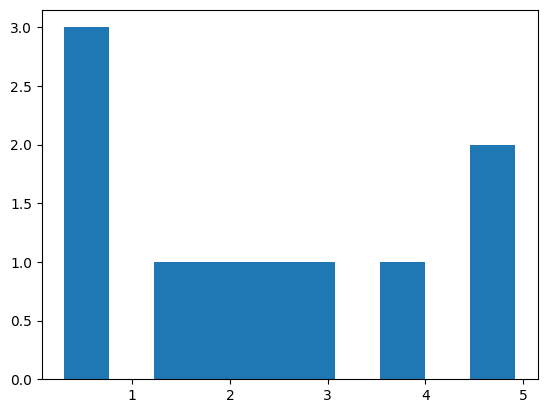

In [18]:
plt.hist(RMSE_list)

In [20]:
np.mean(RMSE_list)

2.282017326725168